# チューニング技法


1. ニューラルネットワークの多層化:
    - 層増やすと表現力アップ
    - ただし、当たり前だが学習が難しくなる
2. 最適化関数の改善:
    1. SGD:
        - 最適化の基本
        - データ1つずつで勾配更新
    2. Momentum:
        - 勾配降下法に慣性を追加することで、最適化をスムーズにする手法
        - 前回の更新分を考慮し、局所最適解を素早く抜け出すことができる
        - ハイパーパラメータであるモーメンタム係数（通常は0.9程度）を設定して利用
    3. Adam:
        - 勾配の1次モーメント（平均）と2次モーメント（分散）を利用してパラメータごとに学習率を調整する
        - 学習率が自動的に調整されるため、学習が安定し、速く収束することが多い
        - ハイパーパラメータはほとんど調整不要で、デフォルト設定で良い結果が得られることが多い
3. その他手法:
    1. ドロップアウト:
        - ニューロンランダム無効化
        - 過学習防止
    2. Batch Norm:
        - ミニバッチ内の各特徴量を平均0、分散1に正規化することで、学習を安定させる手法
        - 活性化関数の前後に適用されることが多い
        - 深いニューラルネットで効果が大きく、学習速度の向上や過学習の抑制に寄与
        - 他と違って学習対象となるパラメータを持つ
    3. Data Aug:
        - 入力データにランダムな変換を加えて、新しいデータを生成する手法
        - 画像データの場合、回転、拡大縮小、平行移動、反転、明るさ変更などが一般的
        - データ量が少ない場合や過学習を抑制したい場合に有効
        - モデルが異なる視点や状況にも対応できるようになり、汎化性能が向上することが期待できる

In [1]:
# 必要なライブラリのインポート
import numpy as np          # 数値計算ライブラリ
import matplotlib.pyplot as plt    # グラフ描画ライブラリ
import torch                 # 機械学習ライブラリPyTorch
from torch import nn        # PyTorchのニューラルネットワークモジュール
from torchviz import make_dot      # PyTorchのグラフ可視化ツール
import japanize_matplotlib  # matplotlibの日本語表示を可能にするライブラリ
import torch.optim as optim # PyTorchの最適化アルゴリズムを定義するoptimモジュール
import pandas as pd         # データフレーム処理のためのライブラリ
import sklearn              # 機械学習ライブラリscikit-learn
from torchinfo import summary   # モデルのサマリー情報を表示するためのライブラリ
from sklearn.model_selection import train_test_split  # データのトレーニングとテストの分割を行う関数
from sklearn.metrics import accuracy_score   # 正解率を計算するための関数
import torchvision.datasets as datasets # PyTorchのデータセットモジュール
import torchvision.transforms as transforms # PyTorchのデータ変換モジュール
from my_lib import torch_seed,fit , evaluate_history , show_images_labels,show_function  # 自作ライブラリ,


In [2]:
# transformの定義
transform = transforms.Compose([
    transforms.ToTensor(), # テンソルに変換
    transforms.Normalize((0.5,), (0.5,)) # 正規化
])

root = './CIFAR_data' # データセットの保存先
# データセットのダウンロード
train_set =  datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
test_set =  datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
print(len(train_set), len(test_set))
# データセットの分
bach_size = 100

# データローダーの定義
train_loader = torch.utils.data.DataLoader(train_set, batch_size=bach_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=bach_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

images,labels = next(iter(train_loader))
print(images.shape)

Files already downloaded and verified
Files already downloaded and verified
50000 10000
torch.Size([100, 3, 32, 32])


In [3]:
# # モデルの定義
# class CNN(nn.Module):
#     def __init__(self,n_output,n_hidden):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3)
#         self.conv2 = nn.Conv2d(32, 32, 3)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(2, 2)
#         self.flatten = nn.Flatten()
#         self.li1 = nn.Linear(int(28*28*32/4) ,n_hidden)
#         self.li2 = nn.Linear(n_hidden, n_output)
#         self.features = nn.Sequential(
#             self.conv1,
#             self.relu,
#             self.conv2,
#             self.relu,
#             self.pool,
#         )
#         self.classifier = nn.Sequential(
#             self.li1,
#             self.relu,
#             self.li2,
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.flatten(x)
#         x = self.classifier(x)
#         return x
    

In [4]:
# # ハイパーパラメータの定義
# lr = 0.001
# num_epochs = 10
# hidden_units = 128
# n_output = len(train_set.classes)
# net = CNN(n_output,hidden_units) 

# # 損失関数の定義
# criterion = nn.CrossEntropyLoss()

# # 最適化手法の定義
# optimizer = optim.SGD(net.parameters(), lr=lr)

# # 状態辞書をロード
# checkpoint = torch.load('MyModel_checkpoint.pth')

# # モデル、オプティマイザの状態を復元
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# history = checkpoint['history']

# net = net.to(device)


In [5]:
# show_images_labels(test_loader, train_set.classes, net, device)


## 1. ニューラルネットワークの多層化

In [6]:
# モデルの定義
# 畳み込み畳み込み→プーリング→×3→全結合
class CNN2(nn.Module):
    def __init__(self,n_output,n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3,padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3,padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3,padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.li1 = nn.Linear(int(128*32/8*32/8) ,n_hidden)
        self.li2 = nn.Linear(n_hidden, n_output)
        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.pool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.pool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.pool
        )
        self.classifier = nn.Sequential(
            self.li1,
            self.relu,
            self.li2,
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    

In [7]:
# 共通のもの
hidden_units = 128
n_output = len(train_set.classes)
lr = 0.01
torch_seed()
num_epochs = 50

# ニューラルネットワークの多層化のみ

net = CNN2(n_output,hidden_units).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0,5))

history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

# モデルの保存
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, 'MyModel2_checkpoint.pth')

torch seed set


  2%|▏         | 1/50 [00:18<15:29, 18.97s/it]

epoch:1/50,train_loss:2.3031,test_loss:2.3028,train_acc:0.1000,test_acc:0.1000


  4%|▍         | 2/50 [00:37<14:46, 18.48s/it]

epoch:2/50,train_loss:2.3027,test_loss:2.3025,train_acc:0.1000,test_acc:0.1000


  6%|▌         | 3/50 [00:55<14:19, 18.28s/it]

epoch:3/50,train_loss:2.3025,test_loss:2.3023,train_acc:0.1000,test_acc:0.1000


  8%|▊         | 4/50 [01:13<13:56, 18.18s/it]

epoch:4/50,train_loss:2.3023,test_loss:2.3021,train_acc:0.1084,test_acc:0.1017


 10%|█         | 5/50 [01:31<13:35, 18.12s/it]

epoch:5/50,train_loss:2.3020,test_loss:2.3016,train_acc:0.1302,test_acc:0.1747


 12%|█▏        | 6/50 [01:49<13:15, 18.08s/it]

epoch:6/50,train_loss:2.3012,test_loss:2.3003,train_acc:0.1674,test_acc:0.1911


 14%|█▍        | 7/50 [02:07<12:58, 18.10s/it]

epoch:7/50,train_loss:2.2981,test_loss:2.2936,train_acc:0.1853,test_acc:0.2185


 16%|█▌        | 8/50 [02:25<12:40, 18.10s/it]

epoch:8/50,train_loss:2.2455,test_loss:2.0970,train_acc:0.2190,test_acc:0.2388


 18%|█▊        | 9/50 [02:43<12:22, 18.12s/it]

epoch:9/50,train_loss:2.0163,test_loss:1.9453,train_acc:0.2612,test_acc:0.2936


 20%|██        | 10/50 [03:01<12:06, 18.17s/it]

epoch:10/50,train_loss:1.9065,test_loss:1.8953,train_acc:0.3127,test_acc:0.3130


 22%|██▏       | 11/50 [03:20<11:49, 18.19s/it]

epoch:11/50,train_loss:1.7963,test_loss:1.7015,train_acc:0.3513,test_acc:0.3859


 24%|██▍       | 12/50 [03:38<11:31, 18.21s/it]

epoch:12/50,train_loss:1.6970,test_loss:1.6263,train_acc:0.3833,test_acc:0.4132


 26%|██▌       | 13/50 [03:56<11:15, 18.25s/it]

epoch:13/50,train_loss:1.6285,test_loss:1.5585,train_acc:0.4065,test_acc:0.4287


 28%|██▊       | 14/50 [04:14<10:57, 18.25s/it]

epoch:14/50,train_loss:1.5740,test_loss:1.6059,train_acc:0.4219,test_acc:0.4185


 30%|███       | 15/50 [04:32<10:35, 18.17s/it]

epoch:15/50,train_loss:1.5300,test_loss:1.5111,train_acc:0.4387,test_acc:0.4431


 32%|███▏      | 16/50 [04:50<10:16, 18.12s/it]

epoch:16/50,train_loss:1.4808,test_loss:1.4387,train_acc:0.4598,test_acc:0.4753


 34%|███▍      | 17/50 [05:09<09:57, 18.12s/it]

epoch:17/50,train_loss:1.4399,test_loss:1.4009,train_acc:0.4749,test_acc:0.4832


 36%|███▌      | 18/50 [05:25<09:28, 17.75s/it]

epoch:18/50,train_loss:1.3975,test_loss:1.4113,train_acc:0.4932,test_acc:0.4899


 38%|███▊      | 19/50 [05:42<09:02, 17.48s/it]

epoch:19/50,train_loss:1.3533,test_loss:1.3335,train_acc:0.5140,test_acc:0.5156


 40%|████      | 20/50 [05:59<08:38, 17.29s/it]

epoch:20/50,train_loss:1.3096,test_loss:1.2998,train_acc:0.5329,test_acc:0.5290


 42%|████▏     | 21/50 [06:16<08:17, 17.16s/it]

epoch:21/50,train_loss:1.2580,test_loss:1.2310,train_acc:0.5508,test_acc:0.5563


 44%|████▍     | 22/50 [06:33<07:58, 17.07s/it]

epoch:22/50,train_loss:1.2169,test_loss:1.2085,train_acc:0.5680,test_acc:0.5638


 46%|████▌     | 23/50 [06:50<07:39, 17.00s/it]

epoch:23/50,train_loss:1.1735,test_loss:1.1925,train_acc:0.5839,test_acc:0.5762


 48%|████▊     | 24/50 [07:07<07:20, 16.96s/it]

epoch:24/50,train_loss:1.1413,test_loss:1.1501,train_acc:0.5947,test_acc:0.5881


 50%|█████     | 25/50 [07:23<07:03, 16.93s/it]

epoch:25/50,train_loss:1.0969,test_loss:1.1318,train_acc:0.6112,test_acc:0.5951


 52%|█████▏    | 26/50 [07:40<06:45, 16.91s/it]

epoch:26/50,train_loss:1.0602,test_loss:1.0966,train_acc:0.6257,test_acc:0.6152


 54%|█████▍    | 27/50 [07:57<06:28, 16.90s/it]

epoch:27/50,train_loss:1.0213,test_loss:1.1124,train_acc:0.6417,test_acc:0.6075


 56%|█████▌    | 28/50 [08:14<06:11, 16.89s/it]

epoch:28/50,train_loss:0.9856,test_loss:1.0572,train_acc:0.6520,test_acc:0.6307


 58%|█████▊    | 29/50 [08:31<05:54, 16.88s/it]

epoch:29/50,train_loss:0.9542,test_loss:1.0114,train_acc:0.6683,test_acc:0.6443


 60%|██████    | 30/50 [08:48<05:37, 16.89s/it]

epoch:30/50,train_loss:0.9168,test_loss:0.9851,train_acc:0.6806,test_acc:0.6549


 62%|██████▏   | 31/50 [09:05<05:20, 16.88s/it]

epoch:31/50,train_loss:0.8860,test_loss:0.9730,train_acc:0.6902,test_acc:0.6620


 64%|██████▍   | 32/50 [09:22<05:03, 16.87s/it]

epoch:32/50,train_loss:0.8578,test_loss:0.9438,train_acc:0.6996,test_acc:0.6706


 66%|██████▌   | 33/50 [09:38<04:46, 16.88s/it]

epoch:33/50,train_loss:0.8238,test_loss:0.9763,train_acc:0.7131,test_acc:0.6622


 68%|██████▊   | 34/50 [09:55<04:30, 16.88s/it]

epoch:34/50,train_loss:0.7949,test_loss:0.9135,train_acc:0.7232,test_acc:0.6840


 70%|███████   | 35/50 [10:12<04:14, 16.94s/it]

epoch:35/50,train_loss:0.7608,test_loss:0.9454,train_acc:0.7365,test_acc:0.6725


 72%|███████▏  | 36/50 [10:29<03:57, 16.99s/it]

epoch:36/50,train_loss:0.7340,test_loss:0.9272,train_acc:0.7438,test_acc:0.6804


 74%|███████▍  | 37/50 [10:47<03:41, 17.02s/it]

epoch:37/50,train_loss:0.7054,test_loss:0.9558,train_acc:0.7532,test_acc:0.6818


 76%|███████▌  | 38/50 [11:04<03:24, 17.04s/it]

epoch:38/50,train_loss:0.6744,test_loss:0.9163,train_acc:0.7647,test_acc:0.6903


 78%|███████▊  | 39/50 [11:21<03:07, 17.08s/it]

epoch:39/50,train_loss:0.6423,test_loss:0.9273,train_acc:0.7764,test_acc:0.6925


 80%|████████  | 40/50 [11:38<02:50, 17.08s/it]

epoch:40/50,train_loss:0.6175,test_loss:0.9424,train_acc:0.7839,test_acc:0.6917


 82%|████████▏ | 41/50 [11:55<02:33, 17.07s/it]

epoch:41/50,train_loss:0.5878,test_loss:0.9667,train_acc:0.7961,test_acc:0.6839


 84%|████████▍ | 42/50 [12:12<02:16, 17.07s/it]

epoch:42/50,train_loss:0.5591,test_loss:0.9522,train_acc:0.8056,test_acc:0.6987


 86%|████████▌ | 43/50 [12:29<01:59, 17.07s/it]

epoch:43/50,train_loss:0.5287,test_loss:0.9437,train_acc:0.8140,test_acc:0.6944


 88%|████████▊ | 44/50 [12:46<01:42, 17.09s/it]

epoch:44/50,train_loss:0.4969,test_loss:0.9346,train_acc:0.8268,test_acc:0.7009


 90%|█████████ | 45/50 [13:03<01:25, 17.09s/it]

epoch:45/50,train_loss:0.4710,test_loss:1.0900,train_acc:0.8350,test_acc:0.6682


 92%|█████████▏| 46/50 [13:20<01:08, 17.09s/it]

epoch:46/50,train_loss:0.4380,test_loss:1.0226,train_acc:0.8476,test_acc:0.6903


 94%|█████████▍| 47/50 [13:38<00:51, 17.09s/it]

epoch:47/50,train_loss:0.4088,test_loss:0.9970,train_acc:0.8568,test_acc:0.6972


 96%|█████████▌| 48/50 [13:55<00:34, 17.09s/it]

epoch:48/50,train_loss:0.3790,test_loss:1.0654,train_acc:0.8661,test_acc:0.6969


 98%|█████████▊| 49/50 [14:12<00:17, 17.10s/it]

epoch:49/50,train_loss:0.3518,test_loss:1.0242,train_acc:0.8756,test_acc:0.7052


100%|██████████| 50/50 [14:29<00:00, 17.39s/it]

epoch:50/50,train_loss:0.3143,test_loss:1.1001,train_acc:0.8897,test_acc:0.6905


## 2. 最適化関数を変えてみる。
### 2.1 Momentumを追加

In [8]:
# ニューラルネットワークの構造は変えない。Momentumを追加。

net = CNN2(n_output,hidden_units).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history = np.zeros((0,5))

history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

# モデルの保存
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, 'MyModel3_checkpoint.pth')



  2%|▏         | 1/50 [00:17<14:00, 17.15s/it]

epoch:1/50,train_loss:2.2510,test_loss:2.0053,train_acc:0.1431,test_acc:0.2680


  4%|▍         | 2/50 [00:34<13:42, 17.13s/it]

epoch:2/50,train_loss:1.7889,test_loss:1.5714,train_acc:0.3442,test_acc:0.4300


  6%|▌         | 3/50 [00:51<13:24, 17.12s/it]

epoch:3/50,train_loss:1.4538,test_loss:1.3449,train_acc:0.4731,test_acc:0.5159


  8%|▊         | 4/50 [01:08<13:07, 17.13s/it]

epoch:4/50,train_loss:1.2338,test_loss:1.1211,train_acc:0.5596,test_acc:0.5960


 10%|█         | 5/50 [01:25<12:50, 17.13s/it]

epoch:5/50,train_loss:1.0292,test_loss:0.9634,train_acc:0.6353,test_acc:0.6595


 12%|█▏        | 6/50 [01:42<12:33, 17.13s/it]

epoch:6/50,train_loss:0.8660,test_loss:0.8802,train_acc:0.6966,test_acc:0.6935


 14%|█▍        | 7/50 [01:59<12:16, 17.13s/it]

epoch:7/50,train_loss:0.7342,test_loss:0.8076,train_acc:0.7434,test_acc:0.7229


 16%|█▌        | 8/50 [02:17<12:00, 17.16s/it]

epoch:8/50,train_loss:0.6202,test_loss:0.8048,train_acc:0.7832,test_acc:0.7298


 18%|█▊        | 9/50 [02:34<11:42, 17.15s/it]

epoch:9/50,train_loss:0.5297,test_loss:0.7885,train_acc:0.8156,test_acc:0.7375


 20%|██        | 10/50 [02:51<11:25, 17.14s/it]

epoch:10/50,train_loss:0.4521,test_loss:0.8498,train_acc:0.8418,test_acc:0.7351


 22%|██▏       | 11/50 [03:08<11:08, 17.14s/it]

epoch:11/50,train_loss:0.3656,test_loss:0.8183,train_acc:0.8705,test_acc:0.7463


 24%|██▍       | 12/50 [03:25<10:50, 17.13s/it]

epoch:12/50,train_loss:0.3012,test_loss:0.8533,train_acc:0.8932,test_acc:0.7499


 26%|██▌       | 13/50 [03:42<10:33, 17.12s/it]

epoch:13/50,train_loss:0.2480,test_loss:0.9214,train_acc:0.9121,test_acc:0.7494


 28%|██▊       | 14/50 [03:59<10:16, 17.11s/it]

epoch:14/50,train_loss:0.1992,test_loss:1.0373,train_acc:0.9295,test_acc:0.7448


 30%|███       | 15/50 [04:16<09:59, 17.12s/it]

epoch:15/50,train_loss:0.1765,test_loss:1.0795,train_acc:0.9360,test_acc:0.7438


 32%|███▏      | 16/50 [04:34<09:41, 17.11s/it]

epoch:16/50,train_loss:0.1486,test_loss:1.1656,train_acc:0.9472,test_acc:0.7461


 34%|███▍      | 17/50 [04:50<09:22, 17.05s/it]

epoch:17/50,train_loss:0.1301,test_loss:1.1738,train_acc:0.9536,test_acc:0.7507


 36%|███▌      | 18/50 [05:07<09:03, 17.00s/it]

epoch:18/50,train_loss:0.1067,test_loss:1.3692,train_acc:0.9628,test_acc:0.7430


 38%|███▊      | 19/50 [05:24<08:45, 16.96s/it]

epoch:19/50,train_loss:0.1114,test_loss:1.2601,train_acc:0.9609,test_acc:0.7476


 40%|████      | 20/50 [05:41<08:27, 16.93s/it]

epoch:20/50,train_loss:0.0874,test_loss:1.4528,train_acc:0.9697,test_acc:0.7468


 42%|████▏     | 21/50 [05:58<08:10, 16.91s/it]

epoch:21/50,train_loss:0.0833,test_loss:1.3484,train_acc:0.9713,test_acc:0.7420


 44%|████▍     | 22/50 [06:15<07:53, 16.90s/it]

epoch:22/50,train_loss:0.0797,test_loss:1.6184,train_acc:0.9727,test_acc:0.7376


 46%|████▌     | 23/50 [06:32<07:35, 16.89s/it]

epoch:23/50,train_loss:0.0752,test_loss:1.4484,train_acc:0.9737,test_acc:0.7485


 48%|████▊     | 24/50 [06:49<07:19, 16.89s/it]

epoch:24/50,train_loss:0.0752,test_loss:1.5259,train_acc:0.9743,test_acc:0.7502


 50%|█████     | 25/50 [07:05<07:02, 16.90s/it]

epoch:25/50,train_loss:0.0598,test_loss:1.8586,train_acc:0.9797,test_acc:0.7416


 52%|█████▏    | 26/50 [07:23<06:46, 16.95s/it]

epoch:26/50,train_loss:0.0652,test_loss:1.5375,train_acc:0.9778,test_acc:0.7498


 54%|█████▍    | 27/50 [07:40<06:30, 17.00s/it]

epoch:27/50,train_loss:0.0584,test_loss:1.6885,train_acc:0.9805,test_acc:0.7479


 56%|█████▌    | 28/50 [07:57<06:14, 17.04s/it]

epoch:28/50,train_loss:0.0604,test_loss:1.6742,train_acc:0.9792,test_acc:0.7518


 58%|█████▊    | 29/50 [08:14<05:58, 17.08s/it]

epoch:29/50,train_loss:0.0541,test_loss:1.6923,train_acc:0.9812,test_acc:0.7563


 60%|██████    | 30/50 [08:31<05:42, 17.10s/it]

epoch:30/50,train_loss:0.0527,test_loss:1.7140,train_acc:0.9823,test_acc:0.7505


 62%|██████▏   | 31/50 [08:48<05:25, 17.11s/it]

epoch:31/50,train_loss:0.0579,test_loss:1.7025,train_acc:0.9805,test_acc:0.7461


 64%|██████▍   | 32/50 [09:05<05:08, 17.12s/it]

epoch:32/50,train_loss:0.0493,test_loss:1.6169,train_acc:0.9835,test_acc:0.7593


 66%|██████▌   | 33/50 [09:22<04:50, 17.11s/it]

epoch:33/50,train_loss:0.0448,test_loss:1.7797,train_acc:0.9851,test_acc:0.7553


 68%|██████▊   | 34/50 [09:40<04:33, 17.11s/it]

epoch:34/50,train_loss:0.0424,test_loss:1.7691,train_acc:0.9858,test_acc:0.7551


 70%|███████   | 35/50 [09:57<04:16, 17.12s/it]

epoch:35/50,train_loss:0.0407,test_loss:1.9353,train_acc:0.9868,test_acc:0.7462


 72%|███████▏  | 36/50 [10:14<03:59, 17.09s/it]

epoch:36/50,train_loss:0.0457,test_loss:1.7507,train_acc:0.9851,test_acc:0.7574


 74%|███████▍  | 37/50 [10:31<03:41, 17.06s/it]

epoch:37/50,train_loss:0.0363,test_loss:1.9050,train_acc:0.9878,test_acc:0.7522


 76%|███████▌  | 38/50 [10:48<03:24, 17.05s/it]

epoch:38/50,train_loss:0.0387,test_loss:1.9754,train_acc:0.9875,test_acc:0.7532


 78%|███████▊  | 39/50 [11:05<03:07, 17.05s/it]

epoch:39/50,train_loss:0.0414,test_loss:1.8390,train_acc:0.9867,test_acc:0.7523


 80%|████████  | 40/50 [11:22<02:50, 17.05s/it]

epoch:40/50,train_loss:0.0370,test_loss:2.0406,train_acc:0.9871,test_acc:0.7529


 82%|████████▏ | 41/50 [11:39<02:33, 17.06s/it]

epoch:41/50,train_loss:0.0364,test_loss:2.0060,train_acc:0.9882,test_acc:0.7462


 84%|████████▍ | 42/50 [11:56<02:16, 17.04s/it]

epoch:42/50,train_loss:0.0376,test_loss:1.8977,train_acc:0.9876,test_acc:0.7570


 86%|████████▌ | 43/50 [12:13<01:59, 17.03s/it]

epoch:43/50,train_loss:0.0337,test_loss:2.0631,train_acc:0.9889,test_acc:0.7523


 88%|████████▊ | 44/50 [12:30<01:42, 17.02s/it]

epoch:44/50,train_loss:0.0318,test_loss:2.0270,train_acc:0.9892,test_acc:0.7565


 90%|█████████ | 45/50 [12:47<01:25, 17.01s/it]

epoch:45/50,train_loss:0.0240,test_loss:2.0074,train_acc:0.9920,test_acc:0.7546


 92%|█████████▏| 46/50 [13:04<01:08, 17.01s/it]

epoch:46/50,train_loss:0.0314,test_loss:2.0309,train_acc:0.9902,test_acc:0.7544


 94%|█████████▍| 47/50 [13:21<00:51, 17.03s/it]

epoch:47/50,train_loss:0.0389,test_loss:2.2187,train_acc:0.9875,test_acc:0.7540


 96%|█████████▌| 48/50 [13:38<00:34, 17.07s/it]

epoch:48/50,train_loss:0.0415,test_loss:2.0645,train_acc:0.9867,test_acc:0.7545


 98%|█████████▊| 49/50 [13:55<00:17, 17.05s/it]

epoch:49/50,train_loss:0.0322,test_loss:2.0768,train_acc:0.9894,test_acc:0.7524


100%|██████████| 50/50 [14:12<00:00, 17.06s/it]

epoch:50/50,train_loss:0.0358,test_loss:2.2050,train_acc:0.9886,test_acc:0.7605


In [9]:
# ニューラルネットワークの構造は変えない。Adamに変更

net = CNN2(n_output,hidden_units).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0,5))

history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

# モデルの保存
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, 'MyModel4_checkpoint.pth')

  2%|▏         | 1/50 [00:17<13:57, 17.10s/it]

epoch:1/50,train_loss:2.3115,test_loss:2.3030,train_acc:0.0988,test_acc:0.1000


  4%|▍         | 2/50 [00:34<13:40, 17.10s/it]

epoch:2/50,train_loss:2.3035,test_loss:2.3029,train_acc:0.0999,test_acc:0.1000


  6%|▌         | 3/50 [00:51<13:23, 17.10s/it]

epoch:3/50,train_loss:2.3036,test_loss:2.3029,train_acc:0.0968,test_acc:0.1000


  8%|▊         | 4/50 [01:08<13:06, 17.10s/it]

epoch:4/50,train_loss:2.3034,test_loss:2.3031,train_acc:0.1002,test_acc:0.1000


 10%|█         | 5/50 [01:25<12:49, 17.10s/it]

epoch:5/50,train_loss:2.3035,test_loss:2.3029,train_acc:0.0972,test_acc:0.1000


 12%|█▏        | 6/50 [01:42<12:32, 17.09s/it]

epoch:6/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.0994,test_acc:0.1000


 14%|█▍        | 7/50 [01:59<12:15, 17.10s/it]

epoch:7/50,train_loss:2.3035,test_loss:2.3037,train_acc:0.0991,test_acc:0.1000


 16%|█▌        | 8/50 [02:16<11:59, 17.12s/it]

epoch:8/50,train_loss:2.3035,test_loss:2.3031,train_acc:0.0991,test_acc:0.1000


 18%|█▊        | 9/50 [02:33<11:41, 17.11s/it]

epoch:9/50,train_loss:2.3033,test_loss:2.3036,train_acc:0.0998,test_acc:0.1000


 20%|██        | 10/50 [02:51<11:25, 17.14s/it]

epoch:10/50,train_loss:2.3036,test_loss:2.3031,train_acc:0.0978,test_acc:0.1000


 22%|██▏       | 11/50 [03:08<11:07, 17.13s/it]

epoch:11/50,train_loss:2.3035,test_loss:2.3031,train_acc:0.0987,test_acc:0.1000


 24%|██▍       | 12/50 [03:25<10:51, 17.13s/it]

epoch:12/50,train_loss:2.3034,test_loss:2.3037,train_acc:0.1012,test_acc:0.1000


 26%|██▌       | 13/50 [03:42<10:33, 17.12s/it]

epoch:13/50,train_loss:2.3033,test_loss:2.3037,train_acc:0.1000,test_acc:0.1000


 28%|██▊       | 14/50 [03:59<10:15, 17.11s/it]

epoch:14/50,train_loss:2.3033,test_loss:2.3029,train_acc:0.0992,test_acc:0.1000


 30%|███       | 15/50 [04:16<09:58, 17.10s/it]

epoch:15/50,train_loss:2.3035,test_loss:2.3029,train_acc:0.0987,test_acc:0.1000


 32%|███▏      | 16/50 [04:33<09:41, 17.10s/it]

epoch:16/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.0988,test_acc:0.1000


 34%|███▍      | 17/50 [04:50<09:24, 17.09s/it]

epoch:17/50,train_loss:2.3035,test_loss:2.3034,train_acc:0.1002,test_acc:0.1000


 36%|███▌      | 18/50 [05:07<09:07, 17.10s/it]

epoch:18/50,train_loss:2.3035,test_loss:2.3034,train_acc:0.0989,test_acc:0.1000


 38%|███▊      | 19/50 [05:25<08:50, 17.10s/it]

epoch:19/50,train_loss:2.3033,test_loss:2.3033,train_acc:0.0980,test_acc:0.1000


 40%|████      | 20/50 [05:42<08:39, 17.30s/it]

epoch:20/50,train_loss:2.3034,test_loss:2.3032,train_acc:0.0995,test_acc:0.1000


 42%|████▏     | 21/50 [06:01<08:33, 17.72s/it]

epoch:21/50,train_loss:2.3034,test_loss:2.3031,train_acc:0.0995,test_acc:0.1000


 44%|████▍     | 22/50 [06:20<08:22, 17.96s/it]

epoch:22/50,train_loss:2.3033,test_loss:2.3033,train_acc:0.0981,test_acc:0.1000


 46%|████▌     | 23/50 [06:38<08:09, 18.12s/it]

epoch:23/50,train_loss:2.3034,test_loss:2.3029,train_acc:0.0990,test_acc:0.1000


 48%|████▊     | 24/50 [06:57<07:54, 18.25s/it]

epoch:24/50,train_loss:2.3034,test_loss:2.3030,train_acc:0.0990,test_acc:0.1000


 50%|█████     | 25/50 [07:15<07:37, 18.32s/it]

epoch:25/50,train_loss:2.3034,test_loss:2.3031,train_acc:0.0993,test_acc:0.1000


 52%|█████▏    | 26/50 [07:33<07:20, 18.36s/it]

epoch:26/50,train_loss:2.3035,test_loss:2.3031,train_acc:0.0971,test_acc:0.1000


 54%|█████▍    | 27/50 [07:52<07:03, 18.40s/it]

epoch:27/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.0984,test_acc:0.1000


 56%|█████▌    | 28/50 [08:11<06:45, 18.43s/it]

epoch:28/50,train_loss:2.3035,test_loss:2.3035,train_acc:0.0991,test_acc:0.1000


 58%|█████▊    | 29/50 [08:29<06:27, 18.45s/it]

epoch:29/50,train_loss:2.3034,test_loss:2.3028,train_acc:0.0994,test_acc:0.1000


 60%|██████    | 30/50 [08:47<06:08, 18.42s/it]

epoch:30/50,train_loss:2.3034,test_loss:2.3034,train_acc:0.0984,test_acc:0.1000


 62%|██████▏   | 31/50 [09:06<05:49, 18.41s/it]

epoch:31/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.0998,test_acc:0.1000


 64%|██████▍   | 32/50 [09:24<05:31, 18.44s/it]

epoch:32/50,train_loss:2.3035,test_loss:2.3032,train_acc:0.0983,test_acc:0.1000


 66%|██████▌   | 33/50 [09:43<05:13, 18.46s/it]

epoch:33/50,train_loss:2.3034,test_loss:2.3027,train_acc:0.1006,test_acc:0.1000


 68%|██████▊   | 34/50 [10:01<04:55, 18.48s/it]

epoch:34/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.0991,test_acc:0.1000


 70%|███████   | 35/50 [10:20<04:37, 18.50s/it]

epoch:35/50,train_loss:2.3034,test_loss:2.3031,train_acc:0.1005,test_acc:0.1000


 72%|███████▏  | 36/50 [10:38<04:19, 18.51s/it]

epoch:36/50,train_loss:2.3034,test_loss:2.3038,train_acc:0.0992,test_acc:0.1000


 74%|███████▍  | 37/50 [10:57<04:00, 18.52s/it]

epoch:37/50,train_loss:2.3034,test_loss:2.3039,train_acc:0.1000,test_acc:0.1000


 76%|███████▌  | 38/50 [11:15<03:40, 18.40s/it]

epoch:38/50,train_loss:2.3034,test_loss:2.3029,train_acc:0.0989,test_acc:0.1000


 78%|███████▊  | 39/50 [11:32<03:18, 18.07s/it]

epoch:39/50,train_loss:2.3034,test_loss:2.3034,train_acc:0.0966,test_acc:0.1000


 80%|████████  | 40/50 [11:50<02:58, 17.83s/it]

epoch:40/50,train_loss:2.3034,test_loss:2.3031,train_acc:0.0984,test_acc:0.1000


 82%|████████▏ | 41/50 [12:07<02:38, 17.65s/it]

epoch:41/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.0986,test_acc:0.1000


 84%|████████▍ | 42/50 [12:24<02:20, 17.54s/it]

epoch:42/50,train_loss:2.3035,test_loss:2.3031,train_acc:0.0987,test_acc:0.1000


 86%|████████▌ | 43/50 [12:41<02:02, 17.45s/it]

epoch:43/50,train_loss:2.3035,test_loss:2.3032,train_acc:0.0997,test_acc:0.1000


 88%|████████▊ | 44/50 [12:59<01:44, 17.39s/it]

epoch:44/50,train_loss:2.3033,test_loss:2.3033,train_acc:0.0995,test_acc:0.1000


 90%|█████████ | 45/50 [13:16<01:26, 17.33s/it]

epoch:45/50,train_loss:2.3033,test_loss:2.3030,train_acc:0.0985,test_acc:0.1000


 92%|█████████▏| 46/50 [13:33<01:09, 17.30s/it]

epoch:46/50,train_loss:2.3033,test_loss:2.3034,train_acc:0.0990,test_acc:0.1000


 94%|█████████▍| 47/50 [13:50<00:51, 17.28s/it]

epoch:47/50,train_loss:2.3033,test_loss:2.3030,train_acc:0.1003,test_acc:0.1000


 96%|█████████▌| 48/50 [14:07<00:34, 17.26s/it]

epoch:48/50,train_loss:2.3035,test_loss:2.3042,train_acc:0.0971,test_acc:0.1000


 98%|█████████▊| 49/50 [14:25<00:17, 17.25s/it]

epoch:49/50,train_loss:2.3036,test_loss:2.3034,train_acc:0.0994,test_acc:0.1000


100%|██████████| 50/50 [14:42<00:00, 17.65s/it]

epoch:50/50,train_loss:2.3035,test_loss:2.3032,train_acc:0.0985,test_acc:0.1000


In [10]:
# ドロップアウトを追加
# モデルの定義
# 畳み込み畳み込み→プーリング→×3→全結合
class CNN3(nn.Module):
    def __init__(self,n_output,n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3,padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3,padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3,padding=1)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.li1 = nn.Linear(int(128*32/8*32/8) ,n_hidden)
        self.li2 = nn.Linear(n_hidden, n_output)
        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.pool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.pool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.pool,
            self.dropout3
        )
        self.classifier = nn.Sequential(
            self.li1,
            self.relu,
            self.dropout3,
            self.li2,
            
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    

In [11]:
# ニューラルネットワークのドロップアウトを追加。Adam

net = CNN3(n_output,hidden_units).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0,5))

history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

# モデルの保存
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, 'MyModel5_checkpoint.pth')

  2%|▏         | 1/50 [00:17<14:03, 17.22s/it]

epoch:1/50,train_loss:2.3092,test_loss:2.3031,train_acc:0.0982,test_acc:0.1000


  4%|▍         | 2/50 [00:34<13:45, 17.20s/it]

epoch:2/50,train_loss:2.3035,test_loss:2.3031,train_acc:0.0970,test_acc:0.1000


  6%|▌         | 3/50 [00:51<13:30, 17.24s/it]

epoch:3/50,train_loss:2.3034,test_loss:2.3035,train_acc:0.0989,test_acc:0.1000


  8%|▊         | 4/50 [01:08<13:12, 17.23s/it]

epoch:4/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.0981,test_acc:0.1000


 10%|█         | 5/50 [01:26<12:55, 17.23s/it]

epoch:5/50,train_loss:2.3033,test_loss:2.3037,train_acc:0.0999,test_acc:0.1000


 12%|█▏        | 6/50 [01:43<12:37, 17.22s/it]

epoch:6/50,train_loss:2.3035,test_loss:2.3029,train_acc:0.0991,test_acc:0.1000


 14%|█▍        | 7/50 [02:00<12:19, 17.21s/it]

epoch:7/50,train_loss:2.3035,test_loss:2.3027,train_acc:0.0990,test_acc:0.1000


 16%|█▌        | 8/50 [02:17<12:03, 17.22s/it]

epoch:8/50,train_loss:2.3034,test_loss:2.3030,train_acc:0.0989,test_acc:0.1000


 18%|█▊        | 9/50 [02:34<11:45, 17.21s/it]

epoch:9/50,train_loss:2.3033,test_loss:2.3028,train_acc:0.0993,test_acc:0.1000


 20%|██        | 10/50 [02:52<11:28, 17.21s/it]

epoch:10/50,train_loss:2.3034,test_loss:2.3030,train_acc:0.1019,test_acc:0.1000


 22%|██▏       | 11/50 [03:09<11:10, 17.20s/it]

epoch:11/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.1005,test_acc:0.1000


 24%|██▍       | 12/50 [03:26<10:53, 17.20s/it]

epoch:12/50,train_loss:2.3035,test_loss:2.3031,train_acc:0.0979,test_acc:0.1000


 26%|██▌       | 13/50 [03:43<10:36, 17.20s/it]

epoch:13/50,train_loss:2.3033,test_loss:2.3034,train_acc:0.0972,test_acc:0.1000


 28%|██▊       | 14/50 [04:00<10:19, 17.20s/it]

epoch:14/50,train_loss:2.3037,test_loss:2.3029,train_acc:0.0980,test_acc:0.1000


 30%|███       | 15/50 [04:18<10:02, 17.20s/it]

epoch:15/50,train_loss:2.3033,test_loss:2.3033,train_acc:0.0987,test_acc:0.1000


 32%|███▏      | 16/50 [04:35<09:45, 17.22s/it]

epoch:16/50,train_loss:2.3033,test_loss:2.3041,train_acc:0.1006,test_acc:0.1000


 34%|███▍      | 17/50 [04:52<09:28, 17.22s/it]

epoch:17/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.1005,test_acc:0.1000


 36%|███▌      | 18/50 [05:09<09:11, 17.22s/it]

epoch:18/50,train_loss:2.3034,test_loss:2.3028,train_acc:0.0974,test_acc:0.1000


 38%|███▊      | 19/50 [05:27<08:53, 17.21s/it]

epoch:19/50,train_loss:2.3033,test_loss:2.3038,train_acc:0.0978,test_acc:0.1000


 40%|████      | 20/50 [05:44<08:36, 17.21s/it]

epoch:20/50,train_loss:2.3034,test_loss:2.3030,train_acc:0.0992,test_acc:0.1000


 42%|████▏     | 21/50 [06:01<08:18, 17.20s/it]

epoch:21/50,train_loss:2.3033,test_loss:2.3031,train_acc:0.1028,test_acc:0.1000


 44%|████▍     | 22/50 [06:18<08:01, 17.20s/it]

epoch:22/50,train_loss:2.3034,test_loss:2.3037,train_acc:0.1003,test_acc:0.1000


 46%|████▌     | 23/50 [06:35<07:44, 17.20s/it]

epoch:23/50,train_loss:2.3036,test_loss:2.3031,train_acc:0.0981,test_acc:0.1000


 48%|████▊     | 24/50 [06:53<07:27, 17.20s/it]

epoch:24/50,train_loss:2.3034,test_loss:2.3030,train_acc:0.0987,test_acc:0.1000


 50%|█████     | 25/50 [07:10<07:10, 17.20s/it]

epoch:25/50,train_loss:2.3033,test_loss:2.3034,train_acc:0.1022,test_acc:0.1000


 52%|█████▏    | 26/50 [07:27<06:52, 17.20s/it]

epoch:26/50,train_loss:2.3034,test_loss:2.3037,train_acc:0.0993,test_acc:0.1000


 54%|█████▍    | 27/50 [07:44<06:35, 17.20s/it]

epoch:27/50,train_loss:2.3035,test_loss:2.3034,train_acc:0.1010,test_acc:0.1000


 56%|█████▌    | 28/50 [08:01<06:18, 17.19s/it]

epoch:28/50,train_loss:2.3034,test_loss:2.3034,train_acc:0.0992,test_acc:0.1000


 58%|█████▊    | 29/50 [08:19<06:01, 17.20s/it]

epoch:29/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.1003,test_acc:0.1000


 60%|██████    | 30/50 [08:36<05:44, 17.21s/it]

epoch:30/50,train_loss:2.3033,test_loss:2.3034,train_acc:0.0993,test_acc:0.1000


 62%|██████▏   | 31/50 [08:53<05:27, 17.21s/it]

epoch:31/50,train_loss:2.3035,test_loss:2.3031,train_acc:0.0982,test_acc:0.1000


 64%|██████▍   | 32/50 [09:10<05:10, 17.22s/it]

epoch:32/50,train_loss:2.3032,test_loss:2.3036,train_acc:0.1012,test_acc:0.1000


 66%|██████▌   | 33/50 [09:27<04:52, 17.22s/it]

epoch:33/50,train_loss:2.3035,test_loss:2.3030,train_acc:0.0990,test_acc:0.1000


 68%|██████▊   | 34/50 [09:45<04:35, 17.22s/it]

epoch:34/50,train_loss:2.3033,test_loss:2.3031,train_acc:0.1016,test_acc:0.1000


 70%|███████   | 35/50 [10:02<04:18, 17.22s/it]

epoch:35/50,train_loss:2.3034,test_loss:2.3032,train_acc:0.0996,test_acc:0.1000


 72%|███████▏  | 36/50 [10:19<04:00, 17.20s/it]

epoch:36/50,train_loss:2.3033,test_loss:2.3036,train_acc:0.0986,test_acc:0.1000


 74%|███████▍  | 37/50 [10:36<03:43, 17.20s/it]

epoch:37/50,train_loss:2.3033,test_loss:2.3033,train_acc:0.1007,test_acc:0.1000


 76%|███████▌  | 38/50 [10:53<03:26, 17.19s/it]

epoch:38/50,train_loss:2.3034,test_loss:2.3033,train_acc:0.0992,test_acc:0.1000


 78%|███████▊  | 39/50 [11:10<03:08, 17.17s/it]

epoch:39/50,train_loss:2.3034,test_loss:2.3037,train_acc:0.0988,test_acc:0.1000


 80%|████████  | 40/50 [11:28<02:51, 17.14s/it]

epoch:40/50,train_loss:2.3033,test_loss:2.3034,train_acc:0.0992,test_acc:0.1000


 82%|████████▏ | 41/50 [11:45<02:34, 17.12s/it]

epoch:41/50,train_loss:2.3034,test_loss:2.3032,train_acc:0.0980,test_acc:0.1000


 84%|████████▍ | 42/50 [12:02<02:16, 17.12s/it]

epoch:42/50,train_loss:2.3034,test_loss:2.3032,train_acc:0.0986,test_acc:0.1000


 86%|████████▌ | 43/50 [12:19<01:59, 17.13s/it]

epoch:43/50,train_loss:2.3035,test_loss:2.3027,train_acc:0.0996,test_acc:0.1000


 88%|████████▊ | 44/50 [12:36<01:42, 17.12s/it]

epoch:44/50,train_loss:2.3034,test_loss:2.3028,train_acc:0.0986,test_acc:0.1000


 90%|█████████ | 45/50 [12:53<01:25, 17.12s/it]

epoch:45/50,train_loss:2.3035,test_loss:2.3034,train_acc:0.0997,test_acc:0.1000


 92%|█████████▏| 46/50 [13:10<01:08, 17.14s/it]

epoch:46/50,train_loss:2.3035,test_loss:2.3031,train_acc:0.0973,test_acc:0.1000


 94%|█████████▍| 47/50 [13:27<00:51, 17.15s/it]

epoch:47/50,train_loss:2.3034,test_loss:2.3038,train_acc:0.0983,test_acc:0.1000


 96%|█████████▌| 48/50 [13:45<00:34, 17.17s/it]

epoch:48/50,train_loss:2.3034,test_loss:2.3031,train_acc:0.0978,test_acc:0.1000


 98%|█████████▊| 49/50 [14:02<00:17, 17.17s/it]

epoch:49/50,train_loss:2.3035,test_loss:2.3035,train_acc:0.0998,test_acc:0.1000


100%|██████████| 50/50 [14:19<00:00, 17.19s/it]

epoch:50/50,train_loss:2.3034,test_loss:2.3029,train_acc:0.1000,test_acc:0.1000


In [12]:
# さらにモデルにBatchNormalizationを追加
# モデルの定義
# 畳み込み畳み込み→プーリング→×3→全結合
class CNN4(nn.Module):
    def __init__(self,n_output,n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3,padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3,padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3,padding=1)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.li1 = nn.Linear(int(128*32/8*32/8) ,n_hidden)
        self.li2 = nn.Linear(n_hidden, n_output)
        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.pool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.pool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.pool,
            self.dropout3
        )
        self.classifier = nn.Sequential(
            self.li1,
            self.relu,
            self.dropout3,
            self.li2,
            
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    

In [13]:
# ニューラルネットワークのBatchNormalizationを追加。Adam

net = CNN4(n_output,hidden_units).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0,5))

history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

# モデルの保存
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, 'MyModel6_checkpoint.pth')

  2%|▏         | 1/50 [00:18<15:02, 18.42s/it]

epoch:1/50,train_loss:2.1762,test_loss:1.9977,train_acc:0.1673,test_acc:0.1915


  4%|▍         | 2/50 [00:36<14:41, 18.36s/it]

epoch:2/50,train_loss:2.0316,test_loss:1.8985,train_acc:0.1857,test_acc:0.2582


  6%|▌         | 3/50 [00:55<14:22, 18.35s/it]

epoch:3/50,train_loss:1.8615,test_loss:1.6684,train_acc:0.2760,test_acc:0.3426


  8%|▊         | 4/50 [01:13<14:04, 18.35s/it]

epoch:4/50,train_loss:1.6167,test_loss:1.3348,train_acc:0.3846,test_acc:0.5028


 10%|█         | 5/50 [01:31<13:45, 18.35s/it]

epoch:5/50,train_loss:1.4179,test_loss:1.2886,train_acc:0.4794,test_acc:0.5175


 12%|█▏        | 6/50 [01:50<13:26, 18.34s/it]

epoch:6/50,train_loss:1.2777,test_loss:1.0803,train_acc:0.5384,test_acc:0.6073


 14%|█▍        | 7/50 [02:08<13:08, 18.33s/it]

epoch:7/50,train_loss:1.1793,test_loss:0.9896,train_acc:0.5812,test_acc:0.6512


 16%|█▌        | 8/50 [02:26<12:49, 18.32s/it]

epoch:8/50,train_loss:1.1137,test_loss:1.0047,train_acc:0.6068,test_acc:0.6356


 18%|█▊        | 9/50 [02:45<12:31, 18.33s/it]

epoch:9/50,train_loss:1.0562,test_loss:0.8960,train_acc:0.6309,test_acc:0.6901


 20%|██        | 10/50 [03:03<12:14, 18.35s/it]

epoch:10/50,train_loss:1.0144,test_loss:0.8217,train_acc:0.6480,test_acc:0.7136


 22%|██▏       | 11/50 [03:21<11:56, 18.37s/it]

epoch:11/50,train_loss:0.9671,test_loss:0.8124,train_acc:0.6620,test_acc:0.7140


 24%|██▍       | 12/50 [03:40<11:37, 18.36s/it]

epoch:12/50,train_loss:0.9381,test_loss:0.7747,train_acc:0.6779,test_acc:0.7334


 26%|██▌       | 13/50 [03:58<11:18, 18.34s/it]

epoch:13/50,train_loss:0.9015,test_loss:0.7429,train_acc:0.6929,test_acc:0.7458


 28%|██▊       | 14/50 [04:16<10:59, 18.33s/it]

epoch:14/50,train_loss:0.8679,test_loss:0.7522,train_acc:0.7041,test_acc:0.7485


 30%|███       | 15/50 [04:35<10:41, 18.32s/it]

epoch:15/50,train_loss:0.8452,test_loss:0.7064,train_acc:0.7116,test_acc:0.7567


 32%|███▏      | 16/50 [04:53<10:22, 18.32s/it]

epoch:16/50,train_loss:0.8223,test_loss:0.7188,train_acc:0.7224,test_acc:0.7507


 34%|███▍      | 17/50 [05:11<10:04, 18.33s/it]

epoch:17/50,train_loss:0.8039,test_loss:0.6881,train_acc:0.7286,test_acc:0.7630


 36%|███▌      | 18/50 [05:30<09:47, 18.36s/it]

epoch:18/50,train_loss:0.7768,test_loss:0.6927,train_acc:0.7352,test_acc:0.7699


 38%|███▊      | 19/50 [05:48<09:29, 18.37s/it]

epoch:19/50,train_loss:0.7580,test_loss:0.6484,train_acc:0.7482,test_acc:0.7804


 40%|████      | 20/50 [06:07<09:11, 18.39s/it]

epoch:20/50,train_loss:0.7417,test_loss:0.6353,train_acc:0.7503,test_acc:0.7825


 42%|████▏     | 21/50 [06:25<08:53, 18.39s/it]

epoch:21/50,train_loss:0.7377,test_loss:0.6683,train_acc:0.7555,test_acc:0.7835


 44%|████▍     | 22/50 [06:43<08:35, 18.40s/it]

epoch:22/50,train_loss:0.7192,test_loss:0.6600,train_acc:0.7596,test_acc:0.7790


 46%|████▌     | 23/50 [07:02<08:16, 18.40s/it]

epoch:23/50,train_loss:0.7038,test_loss:0.7431,train_acc:0.7650,test_acc:0.7643


 48%|████▊     | 24/50 [07:20<07:58, 18.39s/it]

epoch:24/50,train_loss:0.6947,test_loss:0.6346,train_acc:0.7708,test_acc:0.7898


 50%|█████     | 25/50 [07:38<07:39, 18.36s/it]

epoch:25/50,train_loss:0.6874,test_loss:0.6054,train_acc:0.7727,test_acc:0.7970


 52%|█████▏    | 26/50 [07:57<07:21, 18.38s/it]

epoch:26/50,train_loss:0.6857,test_loss:0.6096,train_acc:0.7707,test_acc:0.7921


 54%|█████▍    | 27/50 [08:15<07:02, 18.39s/it]

epoch:27/50,train_loss:0.6676,test_loss:0.6439,train_acc:0.7776,test_acc:0.7946


 56%|█████▌    | 28/50 [08:34<06:44, 18.39s/it]

epoch:28/50,train_loss:0.6557,test_loss:0.6126,train_acc:0.7821,test_acc:0.7991


 58%|█████▊    | 29/50 [08:52<06:26, 18.41s/it]

epoch:29/50,train_loss:0.6475,test_loss:0.5859,train_acc:0.7856,test_acc:0.8080


 60%|██████    | 30/50 [09:10<06:07, 18.39s/it]

epoch:30/50,train_loss:0.6421,test_loss:0.5591,train_acc:0.7897,test_acc:0.8137


 62%|██████▏   | 31/50 [09:29<05:48, 18.36s/it]

epoch:31/50,train_loss:0.6216,test_loss:0.5588,train_acc:0.7933,test_acc:0.8169


 64%|██████▍   | 32/50 [09:47<05:30, 18.36s/it]

epoch:32/50,train_loss:0.6235,test_loss:0.5788,train_acc:0.7940,test_acc:0.8097


 66%|██████▌   | 33/50 [10:05<05:11, 18.34s/it]

epoch:33/50,train_loss:0.6102,test_loss:0.6121,train_acc:0.7986,test_acc:0.7999


 68%|██████▊   | 34/50 [10:24<04:53, 18.33s/it]

epoch:34/50,train_loss:0.6049,test_loss:0.5723,train_acc:0.8003,test_acc:0.8178


 70%|███████   | 35/50 [10:42<04:34, 18.33s/it]

epoch:35/50,train_loss:0.6024,test_loss:0.5976,train_acc:0.8018,test_acc:0.8067


 72%|███████▏  | 36/50 [11:00<04:16, 18.32s/it]

epoch:36/50,train_loss:0.6025,test_loss:0.5640,train_acc:0.8034,test_acc:0.8190


 74%|███████▍  | 37/50 [11:19<03:58, 18.32s/it]

epoch:37/50,train_loss:0.5911,test_loss:0.5396,train_acc:0.8050,test_acc:0.8270


 76%|███████▌  | 38/50 [11:37<03:39, 18.32s/it]

epoch:38/50,train_loss:0.5864,test_loss:0.5480,train_acc:0.8068,test_acc:0.8212


 78%|███████▊  | 39/50 [11:55<03:21, 18.31s/it]

epoch:39/50,train_loss:0.5768,test_loss:0.5522,train_acc:0.8112,test_acc:0.8143


 80%|████████  | 40/50 [12:14<03:03, 18.31s/it]

epoch:40/50,train_loss:0.5766,test_loss:0.5705,train_acc:0.8121,test_acc:0.8177


 82%|████████▏ | 41/50 [12:32<02:44, 18.30s/it]

epoch:41/50,train_loss:0.5718,test_loss:0.5725,train_acc:0.8118,test_acc:0.8178


 84%|████████▍ | 42/50 [12:50<02:26, 18.31s/it]

epoch:42/50,train_loss:0.5645,test_loss:0.5635,train_acc:0.8164,test_acc:0.8199


 86%|████████▌ | 43/50 [13:08<02:08, 18.30s/it]

epoch:43/50,train_loss:0.5570,test_loss:0.5377,train_acc:0.8159,test_acc:0.8272


 88%|████████▊ | 44/50 [13:27<01:49, 18.31s/it]

epoch:44/50,train_loss:0.5536,test_loss:0.5983,train_acc:0.8190,test_acc:0.8118


 90%|█████████ | 45/50 [13:45<01:31, 18.34s/it]

epoch:45/50,train_loss:0.5436,test_loss:0.5441,train_acc:0.8227,test_acc:0.8277


 92%|█████████▏| 46/50 [14:03<01:13, 18.33s/it]

epoch:46/50,train_loss:0.5408,test_loss:0.5655,train_acc:0.8241,test_acc:0.8218


 94%|█████████▍| 47/50 [14:22<00:54, 18.32s/it]

epoch:47/50,train_loss:0.5428,test_loss:0.5875,train_acc:0.8224,test_acc:0.8150


 96%|█████████▌| 48/50 [14:40<00:36, 18.32s/it]

epoch:48/50,train_loss:0.5360,test_loss:0.5374,train_acc:0.8241,test_acc:0.8315


 98%|█████████▊| 49/50 [14:58<00:18, 18.32s/it]

epoch:49/50,train_loss:0.5258,test_loss:0.5778,train_acc:0.8267,test_acc:0.8216


100%|██████████| 50/50 [15:17<00:00, 18.34s/it]

epoch:50/50,train_loss:0.5283,test_loss:0.5534,train_acc:0.8253,test_acc:0.8297


In [14]:
# 最後にデータを拡張して学習させる

# 訓練データの拡張
train_transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

train_set2 =  datasets.CIFAR10(root=root, train=True, download=True, transform=train_transform2)

bach_size = 100
train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=bach_size, shuffle=True)

Files already downloaded and verified


In [15]:
# 最後のと同じモデルで学習させる

net = CNN4(n_output,hidden_units).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0,5))

history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

# モデルの保存
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, 'MyModel7_checkpoint.pth')

  2%|▏         | 1/50 [00:18<15:03, 18.43s/it]

epoch:1/50,train_loss:2.2431,test_loss:1.9823,train_acc:0.1554,test_acc:0.2092


  4%|▍         | 2/50 [00:36<14:46, 18.47s/it]

epoch:2/50,train_loss:2.0463,test_loss:1.8732,train_acc:0.1858,test_acc:0.2504


  6%|▌         | 3/50 [00:55<14:24, 18.39s/it]

epoch:3/50,train_loss:1.8967,test_loss:1.7050,train_acc:0.2473,test_acc:0.2947


  8%|▊         | 4/50 [01:13<14:04, 18.36s/it]

epoch:4/50,train_loss:1.6955,test_loss:1.4450,train_acc:0.3448,test_acc:0.4550


 10%|█         | 5/50 [01:31<13:45, 18.33s/it]

epoch:5/50,train_loss:1.5726,test_loss:1.2961,train_acc:0.3996,test_acc:0.5263


 12%|█▏        | 6/50 [01:50<13:26, 18.32s/it]

epoch:6/50,train_loss:1.4419,test_loss:1.2819,train_acc:0.4676,test_acc:0.5507


 14%|█▍        | 7/50 [02:08<13:07, 18.31s/it]

epoch:7/50,train_loss:1.3189,test_loss:1.0535,train_acc:0.5287,test_acc:0.6277


 16%|█▌        | 8/50 [02:26<12:48, 18.30s/it]

epoch:8/50,train_loss:1.2130,test_loss:0.9574,train_acc:0.5725,test_acc:0.6578


 18%|█▊        | 9/50 [02:44<12:29, 18.29s/it]

epoch:9/50,train_loss:1.1433,test_loss:0.9098,train_acc:0.6039,test_acc:0.6796


 20%|██        | 10/50 [03:03<12:11, 18.29s/it]

epoch:10/50,train_loss:1.0843,test_loss:0.8365,train_acc:0.6262,test_acc:0.7125


 22%|██▏       | 11/50 [03:21<11:53, 18.29s/it]

epoch:11/50,train_loss:1.0353,test_loss:0.8460,train_acc:0.6425,test_acc:0.7107


 24%|██▍       | 12/50 [03:39<11:36, 18.34s/it]

epoch:12/50,train_loss:1.0013,test_loss:0.8535,train_acc:0.6595,test_acc:0.7236


 26%|██▌       | 13/50 [03:58<11:20, 18.40s/it]

epoch:13/50,train_loss:0.9661,test_loss:0.7449,train_acc:0.6709,test_acc:0.7417


 28%|██▊       | 14/50 [04:17<11:03, 18.44s/it]

epoch:14/50,train_loss:0.9203,test_loss:0.7403,train_acc:0.6870,test_acc:0.7407


 30%|███       | 15/50 [04:35<10:46, 18.47s/it]

epoch:15/50,train_loss:0.8888,test_loss:0.7504,train_acc:0.6982,test_acc:0.7394


 32%|███▏      | 16/50 [04:54<10:28, 18.49s/it]

epoch:16/50,train_loss:0.8614,test_loss:0.7105,train_acc:0.7084,test_acc:0.7526


 34%|███▍      | 17/50 [05:12<10:08, 18.45s/it]

epoch:17/50,train_loss:0.8449,test_loss:0.6812,train_acc:0.7184,test_acc:0.7680


 36%|███▌      | 18/50 [05:30<09:48, 18.39s/it]

epoch:18/50,train_loss:0.8128,test_loss:0.7138,train_acc:0.7292,test_acc:0.7685


 38%|███▊      | 19/50 [05:49<09:29, 18.36s/it]

epoch:19/50,train_loss:0.7960,test_loss:0.7050,train_acc:0.7359,test_acc:0.7644


 40%|████      | 20/50 [06:07<09:10, 18.34s/it]

epoch:20/50,train_loss:0.7791,test_loss:0.6718,train_acc:0.7438,test_acc:0.7675


 42%|████▏     | 21/50 [06:25<08:51, 18.33s/it]

epoch:21/50,train_loss:0.7583,test_loss:0.7133,train_acc:0.7493,test_acc:0.7719


 44%|████▍     | 22/50 [06:43<08:33, 18.33s/it]

epoch:22/50,train_loss:0.7459,test_loss:0.6900,train_acc:0.7533,test_acc:0.7753


 46%|████▌     | 23/50 [07:02<08:14, 18.31s/it]

epoch:23/50,train_loss:0.7369,test_loss:0.7118,train_acc:0.7587,test_acc:0.7717


 48%|████▊     | 24/50 [07:20<07:55, 18.31s/it]

epoch:24/50,train_loss:0.7148,test_loss:0.6616,train_acc:0.7643,test_acc:0.7871


 50%|█████     | 25/50 [07:39<07:38, 18.36s/it]

epoch:25/50,train_loss:0.7029,test_loss:0.5958,train_acc:0.7686,test_acc:0.8054


 52%|█████▏    | 26/50 [07:57<07:20, 18.36s/it]

epoch:26/50,train_loss:0.6919,test_loss:0.6271,train_acc:0.7742,test_acc:0.7926


 54%|█████▍    | 27/50 [08:15<07:03, 18.41s/it]

epoch:27/50,train_loss:0.6789,test_loss:0.5924,train_acc:0.7776,test_acc:0.8020


 56%|█████▌    | 28/50 [08:34<06:45, 18.44s/it]

epoch:28/50,train_loss:0.6702,test_loss:0.6455,train_acc:0.7796,test_acc:0.8015


 58%|█████▊    | 29/50 [08:52<06:27, 18.46s/it]

epoch:29/50,train_loss:0.6516,test_loss:0.5926,train_acc:0.7855,test_acc:0.8139


 60%|██████    | 30/50 [09:11<06:09, 18.48s/it]

epoch:30/50,train_loss:0.6445,test_loss:0.6580,train_acc:0.7894,test_acc:0.7934


 62%|██████▏   | 31/50 [09:29<05:51, 18.49s/it]

epoch:31/50,train_loss:0.6384,test_loss:0.5729,train_acc:0.7901,test_acc:0.8145


 64%|██████▍   | 32/50 [09:48<05:33, 18.50s/it]

epoch:32/50,train_loss:0.6188,test_loss:0.5747,train_acc:0.7987,test_acc:0.8205


 66%|██████▌   | 33/50 [10:07<05:14, 18.51s/it]

epoch:33/50,train_loss:0.6176,test_loss:0.5932,train_acc:0.7971,test_acc:0.8200


 68%|██████▊   | 34/50 [10:25<04:56, 18.51s/it]

epoch:34/50,train_loss:0.6059,test_loss:0.6015,train_acc:0.8009,test_acc:0.8158


 70%|███████   | 35/50 [10:44<04:37, 18.50s/it]

epoch:35/50,train_loss:0.5964,test_loss:0.6187,train_acc:0.8064,test_acc:0.8055


 72%|███████▏  | 36/50 [11:02<04:19, 18.51s/it]

epoch:36/50,train_loss:0.5950,test_loss:0.5872,train_acc:0.8049,test_acc:0.8056


 74%|███████▍  | 37/50 [11:21<04:00, 18.52s/it]

epoch:37/50,train_loss:0.5897,test_loss:0.5573,train_acc:0.8060,test_acc:0.8252


 76%|███████▌  | 38/50 [11:39<03:42, 18.52s/it]

epoch:38/50,train_loss:0.5828,test_loss:0.5567,train_acc:0.8087,test_acc:0.8260


 78%|███████▊  | 39/50 [11:58<03:23, 18.52s/it]

epoch:39/50,train_loss:0.5790,test_loss:0.5765,train_acc:0.8109,test_acc:0.8165


 80%|████████  | 40/50 [12:16<03:05, 18.52s/it]

epoch:40/50,train_loss:0.5740,test_loss:0.5427,train_acc:0.8118,test_acc:0.8275


 82%|████████▏ | 41/50 [12:35<02:46, 18.52s/it]

epoch:41/50,train_loss:0.5663,test_loss:0.5904,train_acc:0.8169,test_acc:0.8186


 84%|████████▍ | 42/50 [12:53<02:28, 18.51s/it]

epoch:42/50,train_loss:0.5589,test_loss:0.6658,train_acc:0.8181,test_acc:0.8055


 86%|████████▌ | 43/50 [13:11<02:09, 18.45s/it]

epoch:43/50,train_loss:0.5611,test_loss:0.5320,train_acc:0.8174,test_acc:0.8273


 88%|████████▊ | 44/50 [13:30<01:50, 18.40s/it]

epoch:44/50,train_loss:0.5425,test_loss:0.5506,train_acc:0.8221,test_acc:0.8337


 90%|█████████ | 45/50 [13:48<01:31, 18.38s/it]

epoch:45/50,train_loss:0.5374,test_loss:0.5431,train_acc:0.8216,test_acc:0.8312


 92%|█████████▏| 46/50 [14:06<01:13, 18.36s/it]

epoch:46/50,train_loss:0.5357,test_loss:0.5272,train_acc:0.8271,test_acc:0.8297


 94%|█████████▍| 47/50 [14:25<00:55, 18.35s/it]

epoch:47/50,train_loss:0.5216,test_loss:0.5625,train_acc:0.8306,test_acc:0.8170


 96%|█████████▌| 48/50 [14:43<00:36, 18.41s/it]

epoch:48/50,train_loss:0.5266,test_loss:0.5818,train_acc:0.8285,test_acc:0.8228


 98%|█████████▊| 49/50 [15:02<00:18, 18.45s/it]

epoch:49/50,train_loss:0.5185,test_loss:0.5429,train_acc:0.8315,test_acc:0.8309


100%|██████████| 50/50 [15:20<00:00, 18.41s/it]

epoch:50/50,train_loss:0.5117,test_loss:0.5164,train_acc:0.8323,test_acc:0.8423


初期状態: 損失: 1.98230 精度: 0.20920
最終状態: 損失: 0.51640 精度: 0.84230


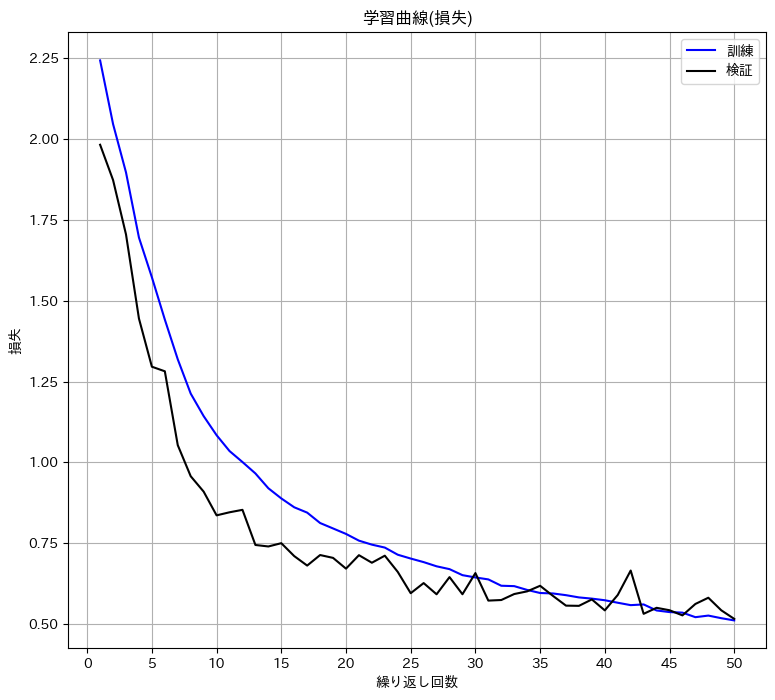

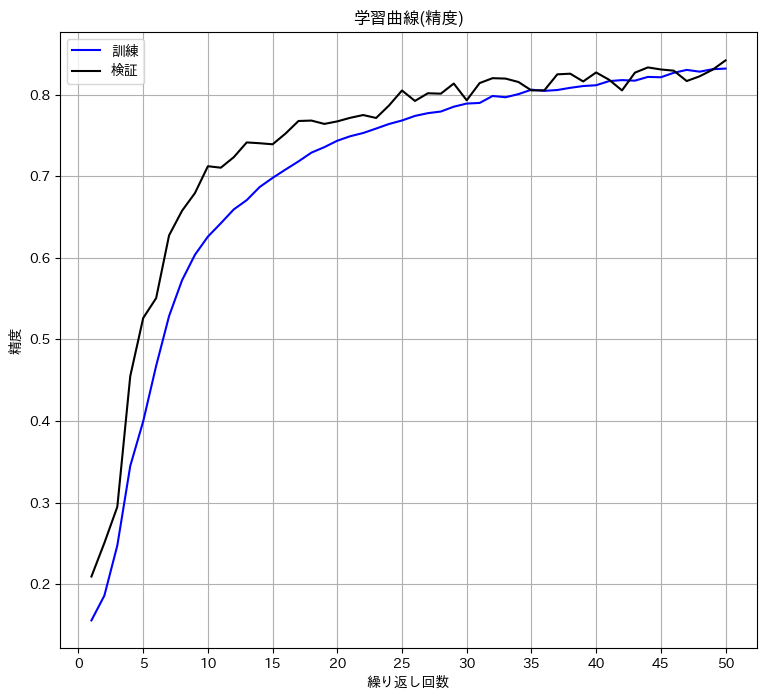

In [17]:
# モデルの読み込み
check_point = torch.load('MyModel7_checkpoint.pth')
net = CNN4(n_output,hidden_units)
net.load_state_dict(check_point['model_state_dict'])
history = check_point['history']

evaluate_history(history)

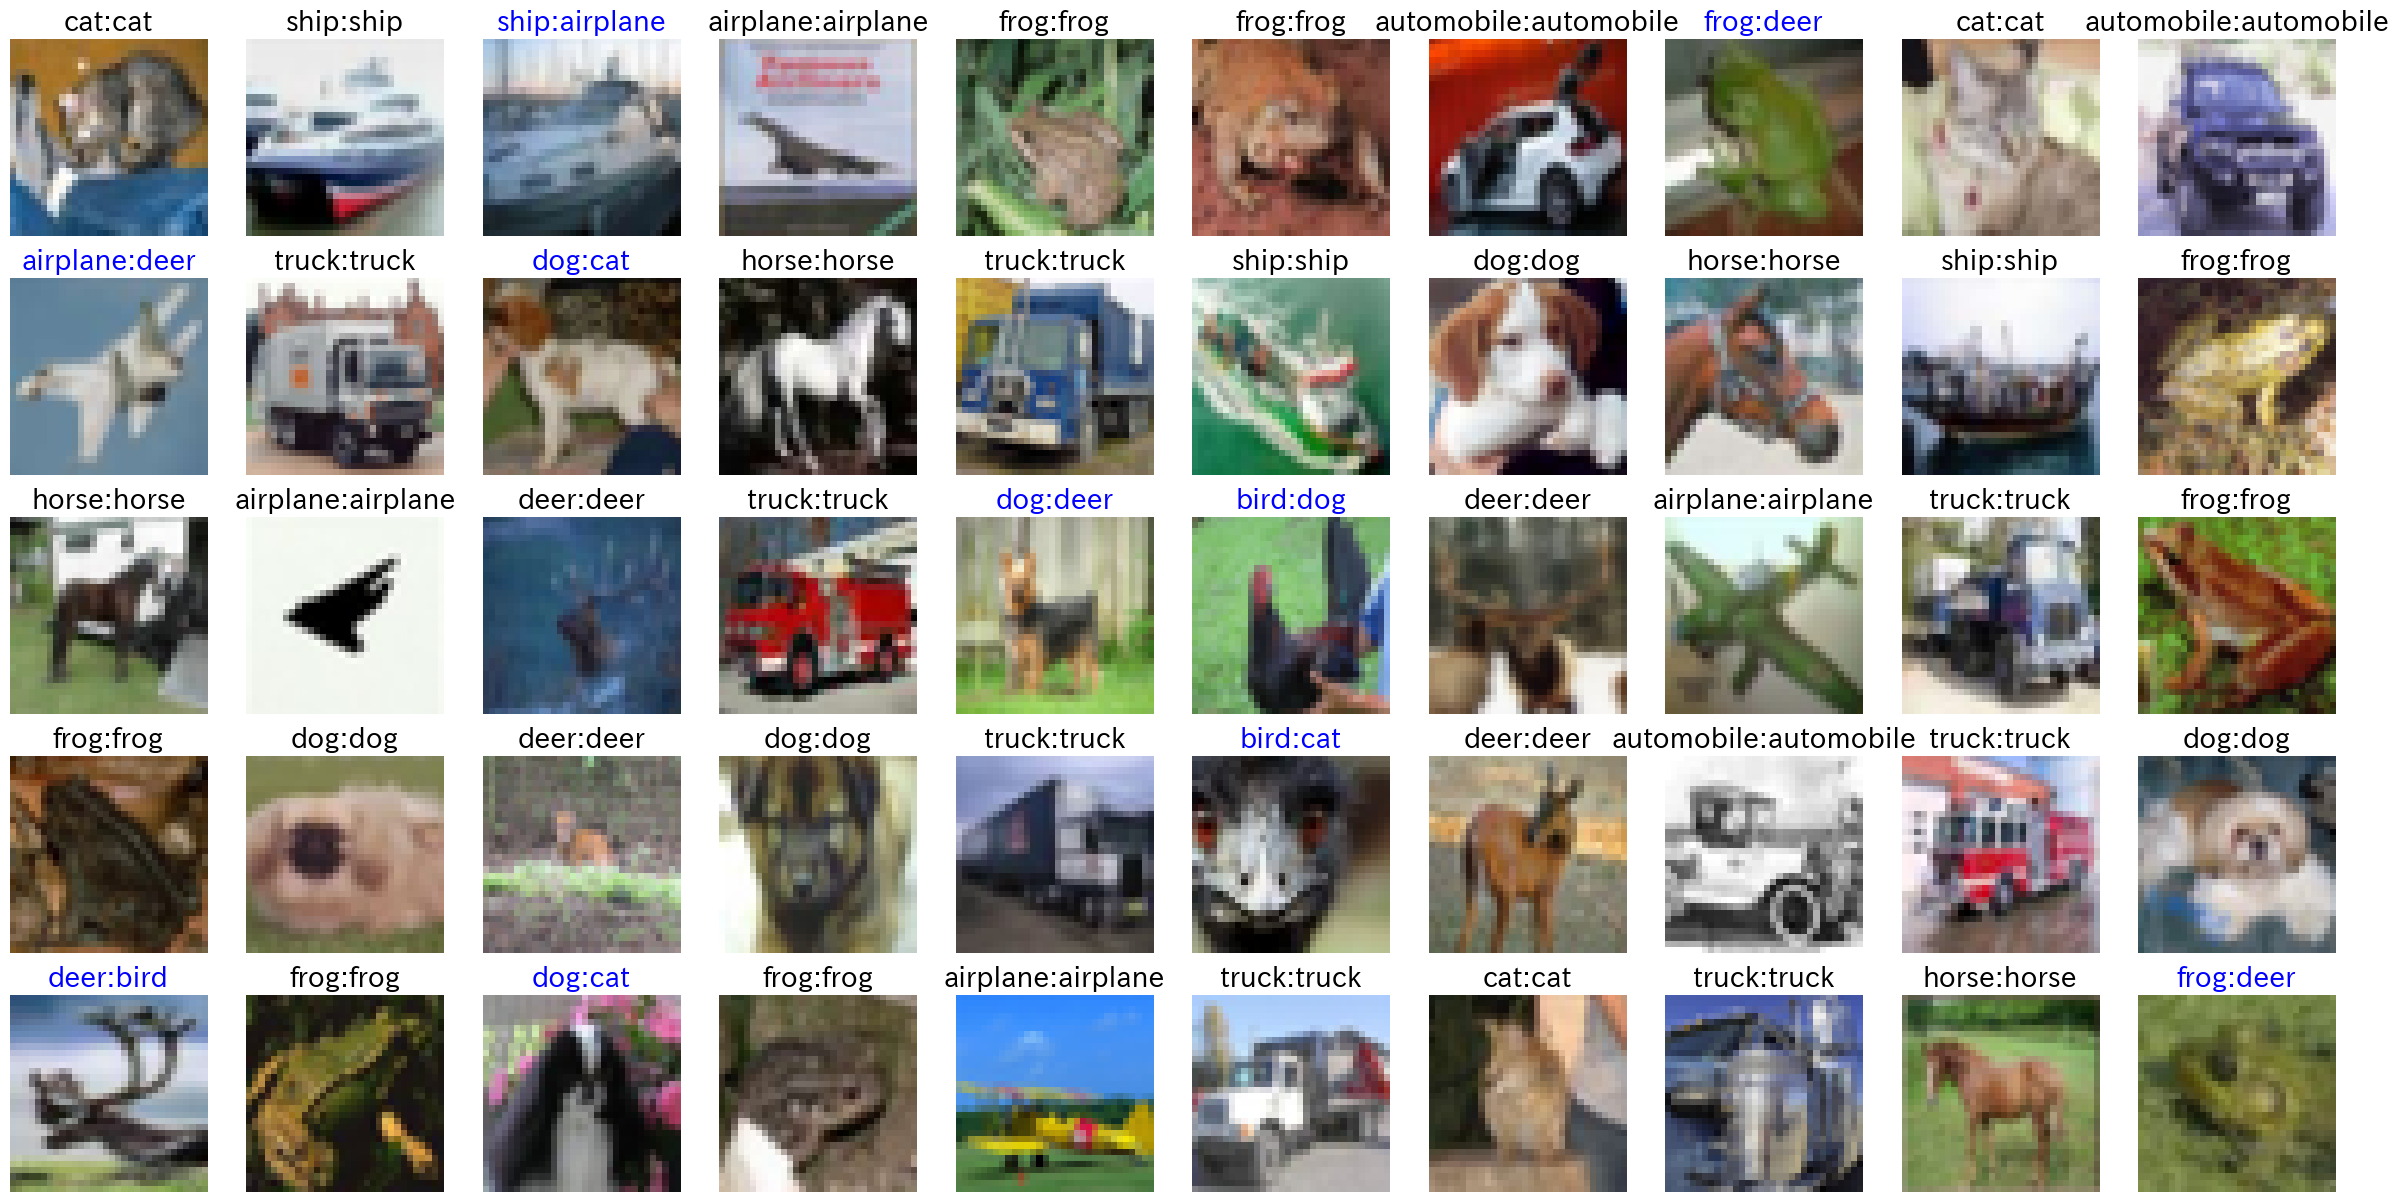

In [22]:
show_images_labels(test_loader, test_set.classes, net.to(device), device)